In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# # # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# # import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


In [2]:
pdb = md.load('./1kx5_full.pdb')
selection = pdb.top.select('resid 0 146')
view = nv.show_mdtraj(pdb)
view.add_representation('surface', selection=selection,color='blue')
view 


NGLWidget()

-3.553786527925016e-17


(-3.0711494803428643,
 14.029449474811553,
 2.577000069618226,
 19.677599024772643,
 -5.87622463107109,
 6.949224585294723)

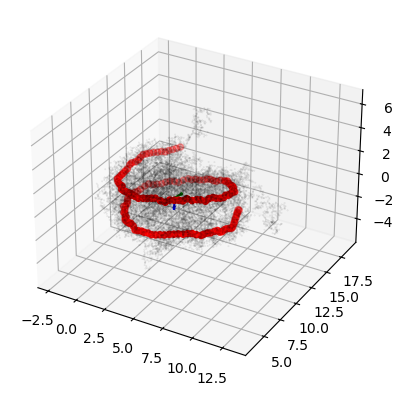

In [55]:
from scipy.linalg import svd
# https://nucldb.intbio.org/help
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4738025/ ref for standard nucleosome reference frame

def find_superhelical_axis(points):
    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)
    
    # Center the points by subtracting the centroid
    centered_points = points + centroid
    
    # Perform Singular Value Decomposition (SVD) to find the principal components
    U, S, Vt = svd(centered_points)
    
    # The principal axis is the last row of Vt corresponding to the smallest singular value
    principal_axis = Vt[-1]
    
    return centroid, principal_axis

# Convert pdb to frames and calculate the mean reference frame
nuc = mdna.NucleicFrames(pdb)
frames = np.squeeze(nuc.mean_reference_frames)
start = frames[0,0,:]
end = frames[-1,0,:]


# Calculate the superhelical axis and center of mass
centers_of_mass = frames[:,0,:]
centroid, z_axis = find_superhelical_axis(centers_of_mass)

# Calculate the x and y axis and Rg
rg = md.compute_rg(pdb)[0]
dna_dyad = pdb.top.select('resSeq 0 and not protein') # Select the DNA dyad 
dyad = md.compute_center_of_mass(pdb.atom_slice(dna_dyad))[0]

y_axis = dyad - centroid
y_axis = y_axis / np.linalg.norm(y_axis)
z_axis = z_axis - np.dot(z_axis, y_axis) * y_axis
z_axis = z_axis / np.linalg.norm(z_axis)

x_axis = np.cross(z_axis, y_axis)
print(np.dot(z_axis, y_axis))
x_axis = x_axis / np.linalg.norm(x_axis)

# # Scale the axis by the Rg
# x_axis = x_axis * rg * 3
# y_axis = y_axis * rg * 3
# z_axis = z_axis * rg * 3

# Plot the xyz coordinates and the Nucleosome Reference Frame
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frames[:,0,0], frames[:,0,1], frames[:,0,2], c='r', marker='o')

# plot the x y and z axis as quiver
ax.quiver(centroid[0], centroid[1], centroid[2], x_axis[0], x_axis[1], x_axis[2], color='r')
ax.quiver(centroid[0], centroid[1], centroid[2], y_axis[0], y_axis[1], y_axis[2], color='g')
ax.quiver(centroid[0], centroid[1], centroid[2], z_axis[0], z_axis[1], z_axis[2], color='b')
ax.scatter(pdb.xyz[0][:,0], pdb.xyz[0][:,1], pdb.xyz[0][:,2], c='k', marker='o',alpha=0.1, s=0.1)
ax.axis('equal')


In [21]:
# Define rotation matrix from axis and angle
def rotation_matrix(axis, theta):
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

In [28]:
mdna.utils.RigidBody.get_rotation_matrix(np.array([0,1,0])*np.pi)

array([[[-1.0000000e+00,  0.0000000e+00,  1.2246468e-16],
        [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [-1.2246468e-16,  0.0000000e+00, -1.0000000e+00]]])

In [47]:
# Convert pdb to frames and calculate the mean reference frame
nuc = mdna.NucleicFrames(pdb)
frames = np.squeeze(nuc.mean_reference_frames)
start = frames[0,0,:]
end = frames[-1,0,:]
end_tangent = frames[-1,-1,:]

In [56]:
frames = np.squeeze(nuc.mean_reference_frames)
start = frames[0,0,:]
end = frames[-1,0,:]
end_tangent = frames[-1,-1,:]

In [70]:
origin = centroid
orientation = np.array([x_axis, y_axis, z_axis])
n_linker_dna = 60
length_linker = n_linker_dna * 0.34 * 0.85
nucleosome_diameter = 2 * rg 
spacing = nucleosome_diameter + length_linker
angle = np.random.uniform(0, np.pi)
axis = end_tangent
print(angle, axis)
R = mdna.utils.RigidBody.get_rotation_matrix(z_axis*angle)[0]
print(R.shape)
new_orientation = np.dot(orientation, R)
new_origin = origin + (spacing * end_tangent)

xyz = pdb.xyz
new_xyz = np.zeros_like(xyz)
new_xyz[0] = np.dot(xyz[0], new_orientation) + new_origin

new_pdb = md.Trajectory(new_xyz, pdb.top)
two = pdb.stack(new_pdb)

2.0948930010498477 [-0.34214568  0.91976574 -0.19226876]
(3, 3)


In [71]:
view = nv.show_mdtraj(two)
view

NGLWidget()

IndexError: index 1 is out of bounds for axis 0 with size 1

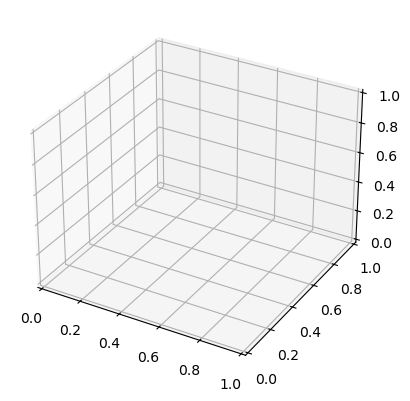

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_origin[0], new_origin[1], new_origin[2], c='r', marker='o')

In [7]:
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
spline = mdna.SplineFrames(control_points)
dna = mdna.StructureGenerator(spline)
spline.frames.shape

AGATGGTTAG


(10, 4, 3)

In [17]:
protein = pdb.atom_slice(pdb.top.select('protein') )

In [13]:
np.squeeze(nuc.mean_reference_frames)
sequence = ''.join(mdna.get_sequence_letters(pdb))
dna = mdna.StructureGenerator(frames=frames,sequence=sequence)

In [20]:
builder = mdna.Build(dna, five_end='A')
builder.extend(nbp=30)
traj = builder.get_traj()
new_traj = traj.stack(protein)
new_traj.save_pdb('nucleosome.pdb')

cycle 0: 
8 moves initated
E = 1499.7017817079313 kT
E = 935.4998046599806 kT
E = 805.9724491751741 kT
E = 782.2711478368655 kT
E = 775.2646846241051 kT
E = 782.8508794599802 kT
8 moves initated
GTGTCGAGCTCGACTTCGAAAGTATATTATCGGCTGAAAAAGGAATCGATTGATAAAGCAGGGCGTCAACGTACCTTGATGAAGAAACGTCGCTCACCCGGCGTATGGCATCCTCATGATCGACAGGTCCTTCGGCGCTCATGACCTAGCTGTCAGAACGCGCCTTTGATAACGGAA


In [103]:
pdb = md.load('./1kx5_full.pdb')
rg = np.round(md.compute_rg(pdb)[0])
# create 2D grid with a box size of nxnxn with each voxel of size rg
#dna = pdb.atom_slice(pdb.top.select('resname == "DA" or resname == "DT" or resname == "DG" or resname == "DC"'))
origin = np.mean(pdb.xyz[0], axis=0)
dna_y_axis = pdb.top.select('resSeq 0 and not protein')
dyad_point = md.compute_center_of_mass(pdb.atom_slice(dna_y_axis))

nuc = mdna.NucleicFrames(pdb)
frames = np.squeeze(nuc.mean_reference_frames)
frames.shape

(147, 4, 3)

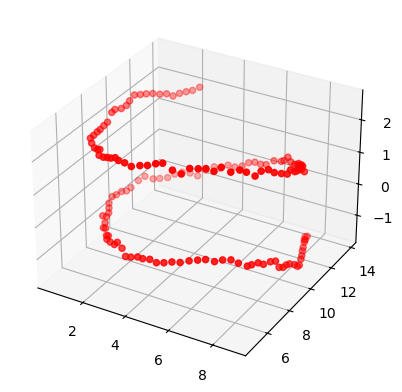

In [104]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frames[:,0,0], frames[:,0,1], frames[:,0,2], c='r', marker='o')

[4.60825664 8.92268993 0.65526383] [-7.81466320e-05 -6.97874671e-02  9.97561879e-01] [ 0.07605661  0.99106293 -0.10958856] [-0.99700914  0.07710073  0.00531571]


(-3.0711494803428643,
 14.029449474811553,
 2.577000069618226,
 19.677599024772643,
 -5.87622463107109,
 6.949224585294723)

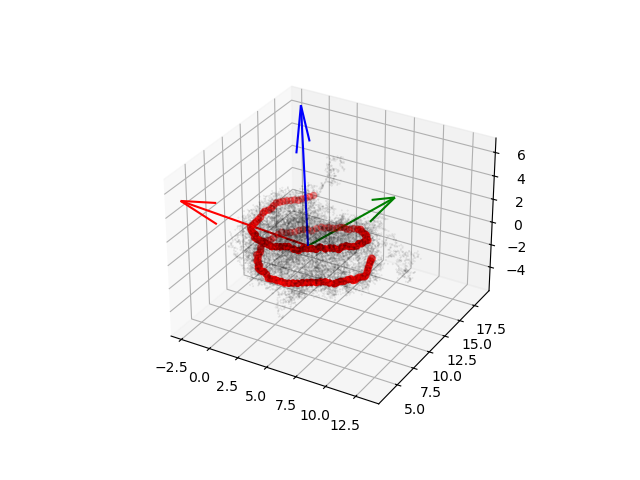

In [107]:
from scipy.linalg import svd

centers_of_mass = frames[:,0,:]


# Perform SVD
U, s, Vt = svd(centers_of_mass)
# The first column of U (or the first row of Vt, transposed) is the first principal component
superhelical_axis = Vt[0]
print("Superhelical axis (approximate Z-axis):", superhelical_axis)

Superhelical axis (approximate Z-axis): [-0.46230259 -0.88511573 -0.05335227]


In [136]:
import numpy as np
from scipy.linalg import svd

def calculate_superhelical_axis(centers_of_mass):
    # Center the data by subtracting the mean
    mean_centered_data = centers_of_mass - np.mean(centers_of_mass, axis=0)

    # Perform SVD
    U, s, Vt = svd(mean_centered_data)

    # The first row of Vt is the first principal component
    return Vt[0]

def minimize_variance(centers_of_mass, axis):
    # Calculate distances from each center of mass to the axis
    # Normalize the axis to unit vector
    axis_norm = axis / np.linalg.norm(axis)
    projections = np.dot(centers_of_mass, axis_norm)
    distances_squared = np.sum((centers_of_mass - np.outer(projections, axis_norm))**2, axis=1)

    # Total variance as the sum of squared distances
    total_variance = np.sum(distances_squared)
    return total_variance

centers_of_mass = frames[:,0,:]

# Compute the initial superhelical axis
superhelical_axis = calculate_superhelical_axis(centers_of_mass)

# # Minimize variance
# variance = minimize_variance(centers_of_mass, superhelical_axis)

print("Superhelical axis (approximate Z-axis):", superhelical_axis)
#print("Total variance around the axis:", variance)


Superhelical axis (approximate Z-axis): [ 0.99507436 -0.07347251 -0.06654932]


(3,) (3,) (3,) (3,)


(-0.35967924594879186,
 9.645438933372498,
 4.280159568786621,
 14.28527774810791,
 -3.242804336547852,
 4.261034297943116)

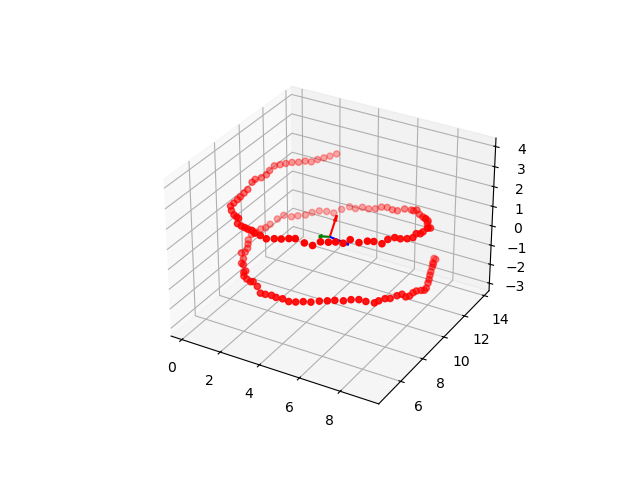

In [135]:
origin = np.mean(pdb.xyz[0], axis=0)
dna_y_axis = pdb.top.select('resSeq 0 and not protein')
dyad_point = md.compute_center_of_mass(pdb.atom_slice(dna_y_axis))


z =  superhelical_axis
y =  origin[0] - dyad_point[0]
x = np.cross(y,z)
# normalize
x = x / np.linalg.norm(x)
y = y / np.linalg.norm(y)
z = z / np.linalg.norm(z)
print(origin.shape, x.shape,y.shape,z.shape)

# plot 
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frames[:,0,0], frames[:,0,1], frames[:,0,2], c='r', marker='o')
# plot the x y and z axis as quiver
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='r')
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='g')
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='b')
ax.axis('equal')

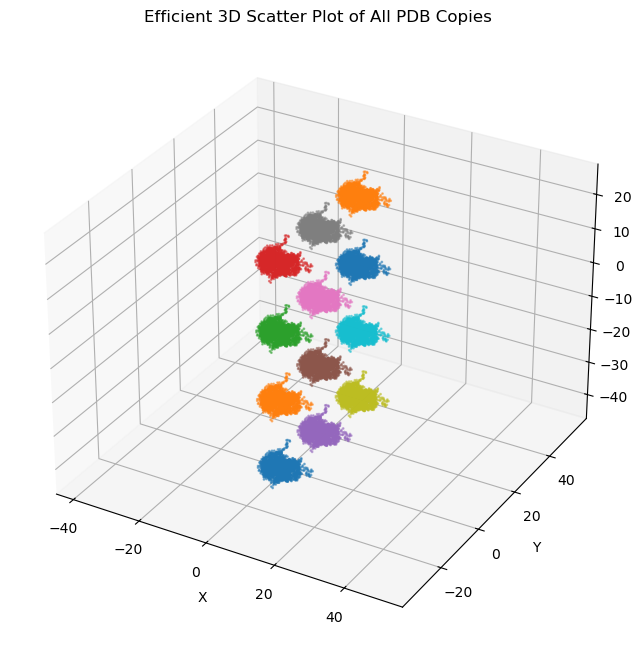

In [7]:

import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load PDB file
pdb = md.load('./1kx5_full.pdb')
start_dna = pdb.top.select('resid 0')
end_dna = pdb.top.select('resid 146')
com_a = md.compute_center_of_mass(pdb.atom_slice(start_dna))
com_b = md.compute_center_of_mass(pdb.atom_slice(end_dna))

# Calculate radius of gyration and define box size
rg = np.round(md.compute_rg(pdb)[0])
box_size = 5 * rg

# Define the grid size for each dimension separately
num_boxes_i = 1  # Number of boxes along x-axis
num_boxes_j = 3  # Number of boxes along y-axis
num_boxes_k = 4  # Number of boxes along z-axis

# Calculate the origin and displacements
origin = np.mean(pdb.xyz[0], axis=0)
displacements_i = (np.arange(num_boxes_i) - num_boxes_i // 2) * box_size
displacements_j = (np.arange(num_boxes_j) - num_boxes_j // 2) * box_size
displacements_k = (np.arange(num_boxes_k) - num_boxes_k // 2) * box_size

# Create meshgrid for the displacement vectors
displacement_vectors = np.stack(np.meshgrid(displacements_i, displacements_j, displacements_k, indexing='ij'), -1).reshape(-1, 3)

# Create the 3D grid and translate all coordinates
all_copies = pdb.xyz[0] + displacement_vectors[:, None, :] + origin - origin


# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for xyz in all_copies:
    ax.scatter(xyz[::10, 0], xyz[::10, 1], xyz[::10, 2], alpha=0.5, s=1)
ax.set_title('Efficient 3D Scatter Plot of All PDB Copies')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
plt.show()

In [8]:
traj_a = md.Trajectory(all_copies[0], pdb.top)
traj_b = md.Trajectory(all_copies[1], pdb.top)
trajs = [md.Trajectory(copy, pdb.top) for copy in all_copies]
traj = trajs[0].stack(trajs[1])
for t in trajs[2:]:
    traj = traj.stack(t)
view = nv.show_mdtraj(traj)
view


NGLWidget()

In [93]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('cartoon') 
view


NGLWidget()

(-31.698716401950904,
 14.095970554714624,
 -19.345301000508023,
 26.449385956157506,
 -26.636507631637755,
 7.709507585861388)

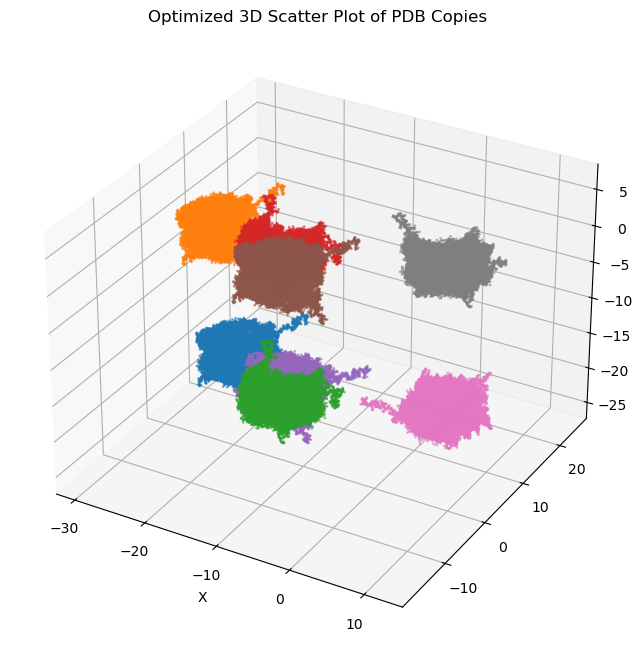

In [83]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Load PDB file
pdb = md.load('./1kx5_full.pdb')
start_dna = pdb.top.select('resid 0')
end_dna = pdb.top.select('resid 146')

# Calculate radius of gyration and define box size
rg = np.round(md.compute_rg(pdb)[0])
box_size = 5 * rg

# Define the grid size for each dimension separately
num_boxes_i = 2  # Number of boxes along x-axis
num_boxes_j = 2  # Number of boxes along y-axis
num_boxes_k = 2  # Number of boxes along z-axis

# Calculate the origin and displacements
origin = np.mean(pdb.xyz[0], axis=0)
displacements_i = (np.arange(num_boxes_i) - num_boxes_i // 2) * box_size
displacements_j = (np.arange(num_boxes_j) - num_boxes_j // 2) * box_size
displacements_k = (np.arange(num_boxes_k) - num_boxes_k // 2) * box_size

# Create meshgrid for the displacement vectors
displacement_vectors = np.stack(np.meshgrid(displacements_i, displacements_j, displacements_k, indexing='ij'), -1).reshape(-1, 3)

# Create the 3D grid and translate all coordinates
all_copies = np.array([pdb.xyz[0] + dv for dv in displacement_vectors])

# Define rotation matrix from axis and angle
def rotation_matrix(axis, theta):
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

# Objective function to minimize
def objective_function(angles):
    angles = angles.reshape(len(displacement_vectors), 3)  # Reshape to 2D array for handling
    total_distance = 0
    rotated_copies = np.copy(all_copies)
    for i in range(len(displacement_vectors)):
        rot_mat = rotation_matrix(np.array([0, 0, 1]), angles[i, 2])  # Rotate around Z-axis
        rotated_copies[i] = np.dot(rotated_copies[i] - origin, rot_mat) + origin
    
    # Calculate total distance between ends of neighboring copies
    for i in range(len(displacement_vectors) - 1):
        com_end = np.mean(rotated_copies[i][end_dna], axis=0)
        com_start_next = np.mean(rotated_copies[i + 1][start_dna], axis=0)
        total_distance += np.linalg.norm(com_end - com_start_next)
    return total_distance

# Optimization setup
initial_angles = np.zeros(len(displacement_vectors) * 3)  # Initial guess: no rotation, flattened array
result = minimize(objective_function, initial_angles, method='BFGS')
optimized_angles = result.x.reshape((len(displacement_vectors), 3))

# Apply optimized rotations for visualization
for i in range(len(displacement_vectors)):
    rot_mat = rotation_matrix(np.array([0, 0, 1]), optimized_angles[i, 2])
    all_copies[i] = np.dot(all_copies[i] - origin, rot_mat) + origin

# Plotting the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for copy in all_copies:
    ax.scatter(copy[:, 0], copy[:, 1], copy[:, 2], alpha=0.5, s=1)
ax.set_title('Optimized 3D Scatter Plot of PDB Copies')
ax.set_xlabel('X')
ax.axis('equal')


In [84]:
traj_a = md.Trajectory(all_copies[0], pdb.top)
traj_b = md.Trajectory(all_copies[1], pdb.top)
trajs = [md.Trajectory(copy, pdb.top) for copy in all_copies]
traj = trajs[0].stack(trajs[1])
for t in trajs[2:]:
    traj = traj.stack(t)
view = nv.show_mdtraj(traj)
view


NGLWidget()

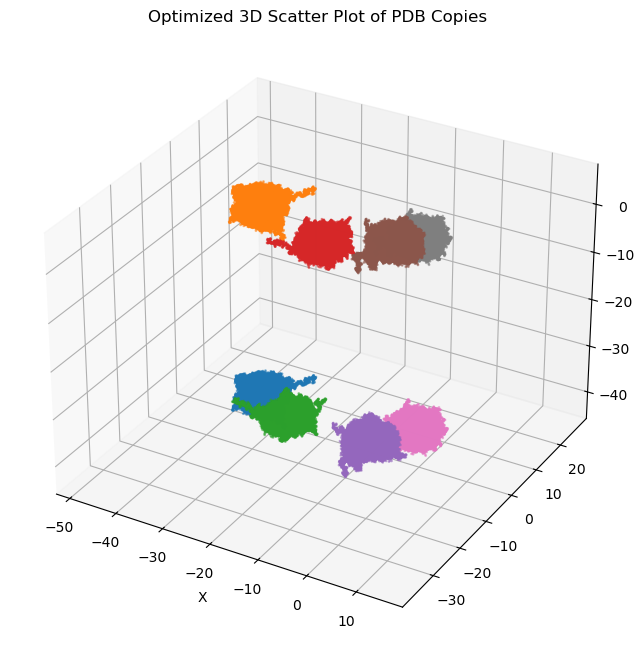

<mdtraj.Topology with 26 chains, 4416 residues, 16755 atoms, 14208 bonds>


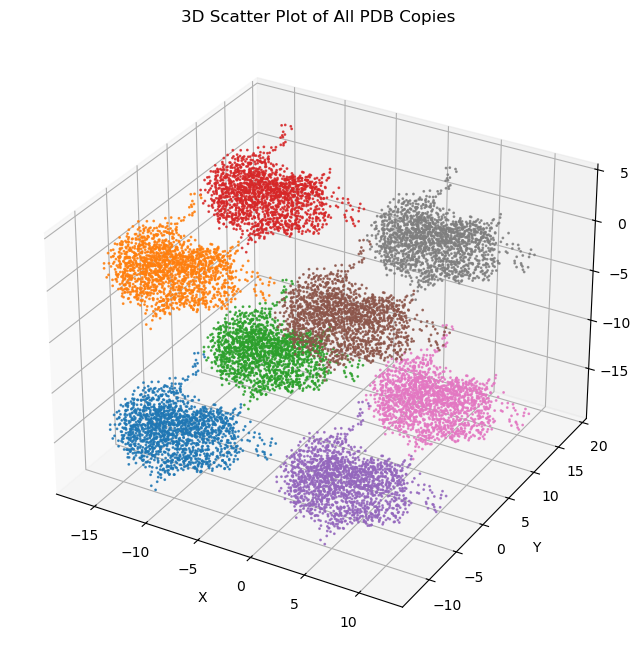

In [87]:
import mdtraj as md
import numpy as np

# Load PDB file
pdb = md.load('./1kx5_full.pdb')
print(pdb.top)
# Calculate radius of gyration and define box size
rg = np.round(md.compute_rg(pdb)[0])
box_size = 4 * rg

# Define the grid size, n x n x n
n = 2  # Define the dimension of the grid along one axis

# Calculate the origin (center) of the grid
origin = np.mean(pdb.xyz[0], axis=0)

# Calculate displacements from the origin for each grid cell
displacements = (np.arange(n) - n // 2) * box_size

# Create the 3D grid and place copies of the PDB structure
all_copies = []
for i in displacements:
    for j in displacements:
        for k in displacements:
            # Compute the center of the box
            center = origin + np.array([i, j, k])
            # Translate all pdb coordinates to the new center
            translated_coordinates = pdb.xyz[0] + center - origin
            all_copies.append(translated_coordinates)

# all_copies contains the translated coordinates for each box in the grid
# This can be further processed or saved as needed
np.array(all_copies).shape

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'all_copies' contains 1000 elements, each a (16755, 3) array
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# We might want to reduce the number of atoms plotted due to performance reasons
sample_rate = 10  # Adjust this number to reduce plotting load, e.g., plot every 10th atom
for coordinates in all_copies:
    ax.scatter(coordinates[::sample_rate, 0], coordinates[::sample_rate, 1], coordinates[::sample_rate, 2], alpha=0.81, s=1)

ax.set_title('3D Scatter Plot of All PDB Copies')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [88]:
traj_a = md.Trajectory(all_copies[0], pdb.top)
traj_b = md.Trajectory(all_copies[1], pdb.top)
trajs = [md.Trajectory(copy, pdb.top) for copy in all_copies]
traj = trajs[0].stack(trajs[1])
for t in trajs[2:]:
    traj = traj.stack(t)
view = nv.show_mdtraj(traj)
view


NGLWidget()

In [57]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Load PDB file
pdb = md.load('./1kx5_full.pdb')
start_dna = pdb.top.select('resid 0')
end_dna = pdb.top.select('resid 146')

# Calculate radius of gyration and define box size
rg = np.round(md.compute_rg(pdb)[0])
box_size = 5 * rg

# Define the grid size for each dimension separately
num_boxes_i = 1  # Number of boxes along x-axis
num_boxes_j = 3  # Number of boxes along y-axis
num_boxes_k = 1  # Number of boxes along z-axis

# Calculate the origin and displacements
origin = np.mean(pdb.xyz[0], axis=0)
displacements_i = (np.arange(num_boxes_i) - num_boxes_i // 2) * box_size
displacements_j = (np.arange(num_boxes_j) - num_boxes_j // 2) * box_size
displacements_k = (np.arange(num_boxes_k) - num_boxes_k // 2) * box_size

# Create meshgrid for the displacement vectors
displacement_vectors = np.stack(np.meshgrid(displacements_i, displacements_j, displacements_k, indexing='ij'), -1).reshape(-1, 3)

# Create the 3D grid and translate all coordinates
all_copies = np.array([pdb.xyz[0] + dv for dv in displacement_vectors])

# Define rotation matrix from axis and angle
def rotation_matrix(axis, theta):
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

# Objective function to minimize
def objective_function(angles):
    total_distance = 0
    rotated_copies = np.copy(all_copies)
    for i, angle in enumerate(angles):
        for j in range(len(displacement_vectors)):
            rot_mat = rotation_matrix(np.array([0, 0, 1]), angle[j])
            rotated_copies[j] = np.dot(rotated_copies[j] - origin, rot_mat) + origin
        
        if i < len(angles) - 1:
            com_end = np.mean(rotated_copies[i][end_dna], axis=0)
            com_start_next = np.mean(rotated_copies[i+1][start_dna], axis=0)
            total_distance += np.linalg.norm(com_end - com_start_next)
    return total_distance

# Optimization setup
initial_angles = np.zeros((len(displacement_vectors), 3))  # Initial guess: no rotation for each copy
result = minimize(objective_function, initial_angles, method='BFGS')
optimized_angles = result.x

# Apply optimized rotations for visualization
for i in range(len(displacement_vectors)):
    angle = optimized_angles[i]
    rot_mat = rotation_matrix(np.array([0, 0, 1]), angle)
    all_copies[i] = np.dot(all_copies[i] - origin, rot_mat) + origin

# Plotting the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for copy in all_copies:
    ax.scatter(copy[:, 0], copy[:, 1], copy[:, 2], alpha=0.5, s=1)
ax.set_title('Optimized 3D Scatter Plot of PDB Copies')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
plt.show()


ValueError: 'x0' must only have one dimension.

In [103]:
frames = np.squeeze(nuc.mean_reference_frames)
test = mdna.StructureGenerator(frames=frames)

ACGTCTTTCTTCTAGGTCACTGTATAATCAGCACGGCTGCTCAAGAGTACTAGGAGACGATTGCAGTCTACTATGAACTAGCCTCACGCTTAGTAAACAATACAGCACATTGTGAAGCAATACCTCGGCTTTAGGCGGAGGACGAGC


In [107]:
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
spline = mdna.SplineFrames(control_points)
dna_b = mdna.StructureGenerator(spline)
dna_b

CCATCAGTGC


Maybe chromatin fiber like vdna too complicated for this purpose, or irrelevant?
Altenative idea, just extend both ends?